In [111]:
from tqdm import tqdm
from full_face_dataset import FullFaceDataset
from torch.utils.data import DataLoader, Subset
from loss_multiface import Yolo_Loss
import matplotlib.pyplot as plt

In [112]:
import torch
import torch.nn as nn
import torchvision.models as models

class RegHead(nn.Module):
    def __init__(self,in_channels, S, B, dropout=0.0):
        super().__init__()
        self.conv0 = nn.Conv2d(in_channels, 1024, 3, padding=1)
        self.conv1 = nn.Conv2d(1024, 1024, 3, padding=1)
        self.conv2 = nn.Conv2d(1024, 1024, 3, padding=1)
        self.conv3 = nn.Conv2d(1024, 1024, 3, padding=1)

        # self.l0 = nn.Linear((4096 * S * S), 4096)
        self.l0 = nn.Linear((1024 * S * S), 4096)
        self.drop = nn.Dropout(dropout)
        self.act = nn.LeakyReLU(0.1)
        self.l1 = nn.Linear(4096, (S * S * (B * 5)))

    def forward(self, x):
        x = self.conv0(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        x = x.flatten(start_dim=1)
        x = self.l0(x)
        x = self.drop(x)
        x = self.act(x)
        x = self.l1(x)
        return x




class FaceDetector(nn.Module):
    def __init__(self, S=7, B=2, dropout=0.0):
        super(FaceDetector, self).__init__()

        backbone = models.resnet50(pretrained=True)
        self.backbone = torch.nn.Sequential(*(list(backbone.children())[:-2]))
        
        self.regression_head = RegHead(2048, S, B, dropout=dropout)
    
    def forward(self, x):
        features = self.backbone(x)
        out = self.regression_head(features)
        return out

In [113]:
model = FaceDetector()

/Users/kuba/.vir-envs/base/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/kuba/.vir-envs/base/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [114]:
for param in model.backbone.parameters():
    param.requires_grad = False

In [115]:
TRAIN_CSV_PATH = '/Users/kuba/Documents/data/raw/face-detection-dataset/train.csv'
TRAIN_IMG_DIR = '/Users/kuba/Documents/data/raw/face-detection-dataset/images/train'
TRAIN_LABELS_DIR = '/Users/kuba/Documents/data/raw/face-detection-dataset/labels/train' 
full_dataset = FullFaceDataset(TRAIN_CSV_PATH, TRAIN_IMG_DIR, TRAIN_LABELS_DIR)

In [116]:
optimizer = torch.optim.SGD(model.regression_head.parameters(), lr=0.001, momentum=0.9)
criterion = Yolo_Loss()

/Users/kuba/.vir-envs/base/lib/python3.11/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [117]:
len(full_dataset)

13386

In [118]:
train_indices = list(range(100))
dev_indices = list(range(100, 150))

# Create Subset datasets
train_dataset = Subset(full_dataset, train_indices)
dev_dataset = Subset(full_dataset, dev_indices)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64)
dev_loader = DataLoader(dev_dataset, batch_size=64)

In [119]:
lossi = []
dev_lossi = []

In [120]:
device = 'mps'
model = model.to(device)

In [121]:
for epoch in tqdm(range(30)):
    loss_total = 0
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_total += loss.item()
    lossi.append(loss_total / len(train_loader))

    dev_loss_total = 0
    model.eval()
    with torch.no_grad():
        for X_dev, y_dev in dev_loader:
            X_dev, y_dev = X_dev.to(device), y_dev.to(device)
            dev_logits = model(X_dev)
            dev_loss = criterion(dev_logits, y_dev)
            dev_loss_total += dev_loss.item()

    dev_lossi.append(dev_loss_total/ len(dev_loader))

100%|██████████| 30/30 [01:05<00:00,  2.19s/it]


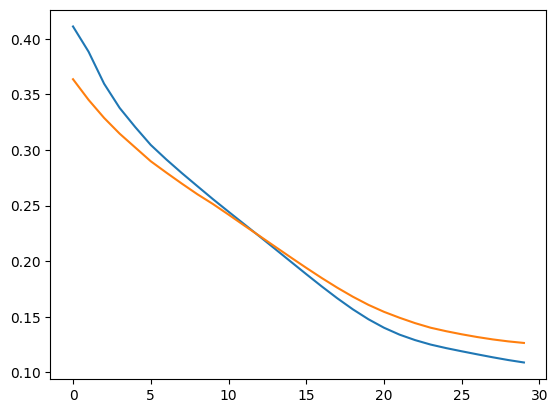

In [122]:
plt.plot(lossi)
plt.plot(dev_lossi)

In [123]:
# for group in optimizer.param_groups:
#     group['lr'] = 0.01

In [124]:
logits = logits.view((-1, 7, 7, 10))
logits.shape

torch.Size([36, 7, 7, 10])

In [137]:
import torch
import torchvision.ops as ops

def non_max_supp(preds, confidence_threshold = 0.35, iou_threshold=0.1, S=7, return_type='xywh'):
    batch_size = preds.shape[0]
    all_res = []


    for i in range(batch_size):
        pred = preds[i]

        all_scores = []
        all_boxes_xyxy = []
        all_boxes_xywh = []
        for row in range(S):
            for col in range(S):

                if pred[row, col][0] < confidence_threshold:
                    continue


                x_cell, y_cell, w_cell, h_cell = pred[row, col][1:5]
                
                x_img = (col + x_cell) / S
                y_img = (row + y_cell) / S
                w_img = w_cell / S
                h_img = h_cell / S
                
                x1 = x_img - w_img / 2
                y1 = y_img - h_img / 2
                x2 = x_img + w_img / 2
                y2 = y_img + h_img / 2

                all_scores.append(pred[row, col][0])
                all_boxes_xyxy.append(torch.tensor((x1,y1,x2,y2))) #for the nms calculation
                all_boxes_xywh.append(torch.tensor((x_img,y_img,w_img,h_img))) #for we will use to plot easy later

        #if no prediction has highenough confidace then we get rid of it
        if len(all_boxes_xyxy) == 0:
            all_res.append(torch.tensor([]))
            continue

        #here we get the idx of the valid boxes after non max suppreshion
        res = ops.nms(torch.stack(all_boxes_xyxy), torch.stack(all_scores), iou_threshold=iou_threshold)
        # for each of the idx we combine now with confidacne  
        if return_type == 'xywh':
            keep_boxes = [ torch.cat((all_scores[idx].unsqueeze(0), all_boxes_xywh[idx][:])) for idx in res]
        elif return_type == 'xyxy':
            keep_boxes = [ torch.cat((all_scores[idx].unsqueeze(0), all_boxes_xyxy[idx][:])) for idx in res]
        #we append to the total preds list for each batch
        all_res.append(torch.stack(keep_boxes))
        
    return all_res


In [138]:
res = non_max_supp(logits.detach().cpu())

In [139]:
def plot_post_non_max(img, preds, preds_type='cx,cy,w,h', labels=[], labels_type='cx,cy,w,h'):
    img = img.permute(1, 2, 0) #to go from (3 x W x H) to (W x H x 3)
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    img_w, img_h = img.shape[:2]

    def plot_cxcywh_style(labels, img_w, img_h, color, marker='ro', show_confidance=False):
         for label in labels:
            confidance, center_x, center_y, width, height = label
            center_x, center_y, width, height = int(center_x * img_w), int(center_y * img_h), int(width * img_w), int(height * img_h)
            xmin = center_x - width/2
            xmax = center_x + width/2
            ymin = center_y - height/2
            ymax = center_y + height/2
            
            #  center and text
            if show_confidance:
                plt.text(center_x, center_y, f"{confidance.item():.3f}", bbox=dict(facecolor='white', alpha=0.35, boxstyle='round'), fontsize=8)
            plt.plot(center_x, center_y, marker)

            
            # (horizontal lines)
            plt.hlines(ymin, xmin=xmin, xmax=xmax, colors=color)
            plt.hlines(ymax, xmin=xmin, xmax=xmax, colors=color)
            
            # (vertical lines)
            plt.vlines(xmin, ymin=ymin, ymax=ymax, colors=color)
            plt.vlines(xmax, ymin=ymin, ymax=ymax, colors=color)
         

    if preds_type == 'cx,cy,w,h':
        plot_cxcywh_style(preds, img_w, img_h, 'red', 'ro', True)

    if len(labels) != 0 and labels_type == 'cx,cy,w,h':
        plot_cxcywh_style(labels, img_w, img_h, 'green', 'g1')
    
    plt.axis('off')
    plt.show()

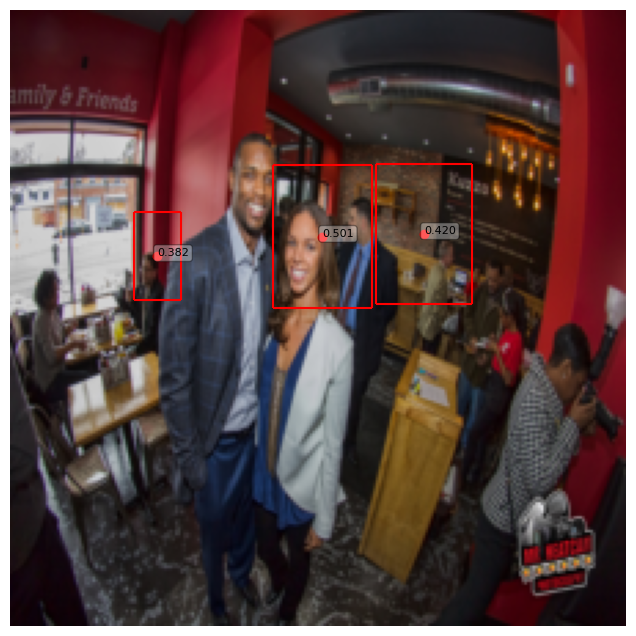

In [146]:
img_num = 30
plot_post_non_max(X_batch[img_num].cpu(), res[img_num])